In [37]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-f80e9374-504a-571b-bac0-6fb00750db4c"
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

In [ ]:
THIS NOTEBOOK DOESN'T WORK AND I DONT KNOW WHY

USE THE COPY

In [12]:
import sys
sys.path.append('../2_train_models')

In [41]:
import numpy as np
import torch
import matplotlib.pyplot as plt

#from data_loading import read_fasta_fast, one_hot_encode

cell_type = "K562"
timestamp = "2022-10-05_03-39-32"
model_type = "strand_merged_umap"
data_type = "procap"

from file_configs import ValFilesConfig, MotifCallsFilesConfig

%matplotlib inline

In [14]:
val_config = ValFilesConfig(cell_type, model_type, timestamp, data_type)
in_window = val_config.in_window
out_window = val_config.out_window

motif_config = MotifCallsFilesConfig(cell_type, model_type, timestamp, "profile", "profile")
slice_len = motif_config.slice

og_pred_profs = np.exp(np.load(val_config.pred_profiles_train_val_path))
og_pred_counts = np.exp(np.load(val_config.pred_logcounts_train_val_path))

Timestamp: 2022-10-05_03-39-32
Timestamp: 2022-10-05_03-39-32


In [15]:
sys.path.append('../5_modisco')
from modiscolite_utils import load_sequences

onehot_seqs = load_sequences(val_config.genome_path,
                             val_config.chrom_sizes,
                             val_config.train_val_peak_path,
                             slice_len=in_window,   ###### code below wants full-length seqs
                             in_window=in_window)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


KeyboardInterrupt: 

In [5]:
def load_model(val_config):
    model = torch.load(val_config.model_save_path)
    model.eval()
    model = model.cuda()
    return model

model = load_model(val_config)

In [16]:
# need to specify for every expt

patterns_to_keep = [0,1,2,3,4,5,7,8,9,10,13,14,15]

profile_to_counts_patterns = {0:[2,5], 1:None, 2:[0,1], 3:7, 4:3, 5:4, 7:9,
                              8:None, 9:None, 10:10, 13:6, 14:-1, 15:None}

# This is specific to K562

motif_keys_to_labels = ["BRE/SP", "CA-Inr", "GABPA/ELK4", "NFY", "NRF1", "ATF1",
                        "YY1", "TA-Inr", "TATA", "THAP11",
                        "AP1",  "CTCF", "ZBTB33"]

motif_keys = list(range(len(motif_keys_to_labels)))

In [17]:
### Load Motifs

from motif_hits_utils import import_motif_hits, filter_peak_hits_by_fdr, make_peak_table, get_peak_hits_with_fix, get_peak_motif_counts



# this function differs slightly from Fig1.ipynb; to-do: standardize input for this

def load_motif_hits(cell_type, model_type, timestamp, fdr_cutoff=0.05):
    filtered_hits = dict()
    peak_hits = dict()
    peak_hit_counts = dict()
    
    for task in ["profile", "counts"]:
        config = MotifCallsFilesConfig(cell_type, model_type, timestamp, "profile", task)
        in_window = config.in_window
        peak_path = config.train_val_peak_path
        modisco_hits_path = config.results_save_path

        hits = import_motif_hits(modisco_hits_path)
        motif_keys = list(set(hits["key"]))

        # Filter motif hit table by p-value using FDR estimation
        filtered_hits[task] = filter_peak_hits_by_fdr(hits, fdr_cutoff=fdr_cutoff)

        train_val_peak_table = make_peak_table(peak_path, in_window)

        # Match peaks to motif hits
        peak_hits[task] = get_peak_hits_with_fix(train_val_peak_table, filtered_hits[task])

        # Count hits of each motif in each peak
        peak_hit_counts[task] = get_peak_motif_counts(peak_hits[task], motif_keys)
    
    return filtered_hits, peak_hits, peak_hit_counts


motif_hits, motif_hits_peaks, motif_hit_counts = load_motif_hits(cell_type, model_type, timestamp)

Timestamp: 2022-10-05_03-39-32
Timestamp: 2022-10-05_03-39-32


In [18]:
motif_hit_counts["profile"].shape

(27000, 13)

In [19]:
def get_motif_locations_in_peaks(peak_hits, peak_path, in_window=in_window):
    peak_table = make_peak_table(peak_path, in_window)
    
    motif_locations_in_peaks = []

    for peak_motif_df in peak_hits:
        motif_locs = []

        if len(peak_motif_df) > 0:
            peak_indexes = list(set(peak_motif_df["peak_index"]))
            assert len(peak_indexes) == 1, peak_indexes
            peak_start = peak_table.loc[peak_indexes[0]]["peak_start"]

            for _, motif_hit in peak_motif_df.iterrows():
                motif_start = motif_hit["start"] - peak_start
                motif_end = motif_hit["end"] - peak_start
                motif_key = motif_hit["key"]
                motif_strand = motif_hit["strand"]

                motif_locs.append((motif_start, motif_end, motif_key, motif_strand))

        motif_locations_in_peaks.append(motif_locs)
        
    return motif_locations_in_peaks

motif_locations_in_peaks = get_motif_locations_in_peaks(motif_hits_peaks["profile"],
                                                       val_config.train_val_peak_path)

In [22]:
import random
import tqdm

def shuffle_subsequence(og_seq_onehot, shuf_start, shuf_end, num_shuffles = 50):
    # Generates a set of shuffled versions of the input sequences
    # (NOT dinuc shuffling)
    
    # TODO: actually check that the motif is gone after shuffling...
    
    assert og_seq_onehot.shape == (4, in_window), og_seq_onehot.shape
    
    shuffled_seqs = np.tile(og_seq_onehot, (num_shuffles, 1, 1))
    assert len(shuffled_seqs.shape) == len(og_seq_onehot.shape) + 1, shuffled_seqs.shape
    
    subseq_to_shuffle = list(og_seq_onehot[:, shuf_start:shuf_end].T)
    subseq_len = len(subseq_to_shuffle)
    assert subseq_len == shuf_end - shuf_start
    
    for i in range(num_shuffles):
        shuffled_subseq = np.array(random.choices(subseq_to_shuffle, k=subseq_len)).T
        
        assert shuffled_subseq.shape == shuffled_seqs[i, :, shuf_start:shuf_end].shape
        
        shuffled_seqs[i, :, shuf_start:shuf_end] = shuffled_subseq
    
    # returns array of shape (num_seqs, 4, seq_len)
    return shuffled_seqs


def ablate_motif_and_predict(model, og_seq_onehot, motif_start, motif_end):
    assert og_seq_onehot.shape == (4, in_window), og_seq_onehot.shape
    
    ablated_seqs = shuffle_subsequence(og_seq_onehot, motif_start, motif_end)
    
    with torch.no_grad():
        ablated_seqs = torch.Tensor(ablated_seqs).cuda()
        pred_profs, pred_logcounts = model.predict(ablated_seqs)
    
    return pred_profs, pred_logcounts


def ablate_and_predict_all_peaks(one_hot_seqs_with_hit, motif_data, model):
    print("Ablating motifs and making predictions across peaks with hits...")
    
    ablated_pred_profs = []
    ablated_pred_logcounts = []
    
    for seq, motif_data in tqdm.notebook.tqdm(zip(one_hot_seqs_with_hit, motif_data),
                                              total = len(motif_data)):
        motif_start, motif_end = motif_data[:2]
    
        # ablate the motif many times and collect all model predictions
        pred_profs, pred_logcounts = ablate_motif_and_predict(model, seq.T,
                                                              motif_start,
                                                              motif_end)

        ablated_pred_profs.append(pred_profs)
        ablated_pred_logcounts.append(pred_logcounts)

    ablated_pred_profs = np.array(ablated_pred_profs)
    ablated_pred_logcounts = np.array(ablated_pred_logcounts)

    return ablated_pred_profs, ablated_pred_logcounts

In [45]:
def get_peaks_with_motif_hit(motif_locations_in_peaks, motif_key):
    print("Looking for motif hits across all peaks...")
    
    # will use this to subset other arrays
    peaks_with_motif_bools = []
    
    # will use this to collect motif start, end, strand
    motif_data = []
    
    for motif_locations in motif_locations_in_peaks:
        peak_hits_for_motif = [hit for hit in motif_locations if hit[2] == motif_key]

        # if at least one hit for this motif in this peak
        if len(peak_hits_for_motif) >= 1:
            peaks_with_motif_bools.append(True)
            
            # if more than one motif in this peak, pick one randomly
            selected_motif_hit = random.choice(peak_hits_for_motif)
            motif_data.append(selected_motif_hit)
        else:
            peaks_with_motif_bools.append(False)
            
    peaks_with_motif_bools = np.array(peaks_with_motif_bools)
    return peaks_with_motif_bools, motif_data


peaks_with_motif_bools = dict()
motif_data = dict()
#ablated_pred_profs = dict()
#ablated_pred_logcounts = dict()


for motif_key, motif_name in enumerate(motif_keys_to_labels):
    print("Motif:", motif_key)

    # first, fetch all of the info needed: subset to only peaks with a motif hit

    peaks_with_motif_bools_tmp, motif_data_tmp = get_peaks_with_motif_hit(motif_locations_in_peaks,
                                                                          motif_key)

    peaks_with_motif_bools[motif_key] = peaks_with_motif_bools_tmp
    motif_data[motif_key] = motif_data_tmp

    # filter to only the seqs/predictions for the peaks that had a motif hit
    #one_hot_seqs_with_hit = onehot_seqs[peaks_with_motif_bools_tmp]
    #val_pred_profs_with_hit = og_pred_profs[peaks_with_motif_bools_tmp]
    #val_pred_counts_with_hit = og_pred_counts[peaks_with_motif_bools_tmp]

    # then, we will iterate over each peak in this subset,
    # ablate the motif, and use the model to predict a profile / count

    #ablated_pred_profs_tmp, ablated_pred_logcounts_tmp = ablate_and_predict_all_peaks(one_hot_seqs_with_hit,
    #                                                                                  motif_data_tmp, model)

    #ablated_pred_profs[motif_key] = ablated_pred_profs_tmp
    #ablated_pred_logcounts[motif_key] = ablated_pred_logcounts_tmp

Motif: 0
Looking for motif hits across all peaks...
Motif: 1
Looking for motif hits across all peaks...
Motif: 2
Looking for motif hits across all peaks...
Motif: 3
Looking for motif hits across all peaks...
Motif: 4
Looking for motif hits across all peaks...
Motif: 5
Looking for motif hits across all peaks...
Motif: 6
Looking for motif hits across all peaks...
Motif: 7
Looking for motif hits across all peaks...
Motif: 8
Looking for motif hits across all peaks...
Motif: 9
Looking for motif hits across all peaks...
Motif: 10
Looking for motif hits across all peaks...
Motif: 11
Looking for motif hits across all peaks...
Motif: 12
Looking for motif hits across all peaks...


In [46]:
motif_data

{0: [(1096, 1121, 0, '+'),
  (1064, 1089, 0, '-'),
  (1117, 1142, 0, '+'),
  (1031, 1056, 0, '+'),
  (1281, 1306, 0, '-'),
  (1017, 1042, 0, '+'),
  (968, 993, 0, '-'),
  (1120, 1145, 0, '+'),
  (1337, 1362, 0, '-'),
  (980, 1005, 0, '-'),
  (1032, 1057, 0, '+'),
  (1083, 1108, 0, '+'),
  (1065, 1090, 0, '+'),
  (976, 1001, 0, '+'),
  (970, 995, 0, '+'),
  (1509, 1534, 0, '-'),
  (1528, 1553, 0, '+'),
  (1023, 1048, 0, '-'),
  (1075, 1100, 0, '+'),
  (1070, 1095, 0, '+'),
  (1171, 1196, 0, '+'),
  (1195, 1220, 0, '+'),
  (1094, 1119, 0, '-'),
  (1218, 1243, 0, '-'),
  (960, 985, 0, '+'),
  (926, 951, 0, '+'),
  (1057, 1082, 0, '+'),
  (973, 998, 0, '-'),
  (728, 753, 0, '-'),
  (1059, 1084, 0, '+'),
  (933, 958, 0, '-'),
  (1036, 1061, 0, '+'),
  (1085, 1110, 0, '+'),
  (1023, 1048, 0, '+'),
  (1044, 1069, 0, '+'),
  (1060, 1085, 0, '-'),
  (1036, 1061, 0, '-'),
  (1049, 1074, 0, '+'),
  (1071, 1096, 0, '+'),
  (1010, 1035, 0, '+'),
  (1478, 1503, 0, '-'),
  (1059, 1084, 0, '+'),
  (11

In [26]:
ablated_pred_profs.keys()

dict_keys([6, 8, 10, 5, 3, 0, 9, 2, 4, 12, 7, 11, 1])

In [42]:
import pickle 

os.makedirs("fig6_data/", exist_ok=True)

for motif_key in motif_keys:
    np.save("fig6_data/ablated_pred_profs_motif_" + str(motif_key), ablated_pred_profs[motif_key])
    np.save("fig6_data/ablated_pred_logcounts_motif_" + str(motif_key), ablated_pred_logcounts[motif_key])

In [9]:
import os

ablated_pred_profs = dict()
ablated_pred_logcounts = dict()

for filepath in os.listdir("fig6_data/"):
    if not "ablated_pred" in filepath:
        continue
    
    motif_key = int(filepath.split("_")[-1].split(".")[0])
    
    if "profs" in filepath:
        ablated_pred_profs[motif_key] = np.load("fig6_data/" + filepath)
    else:
        ablated_pred_logcounts[motif_key] = np.load("fig6_data/" + filepath)

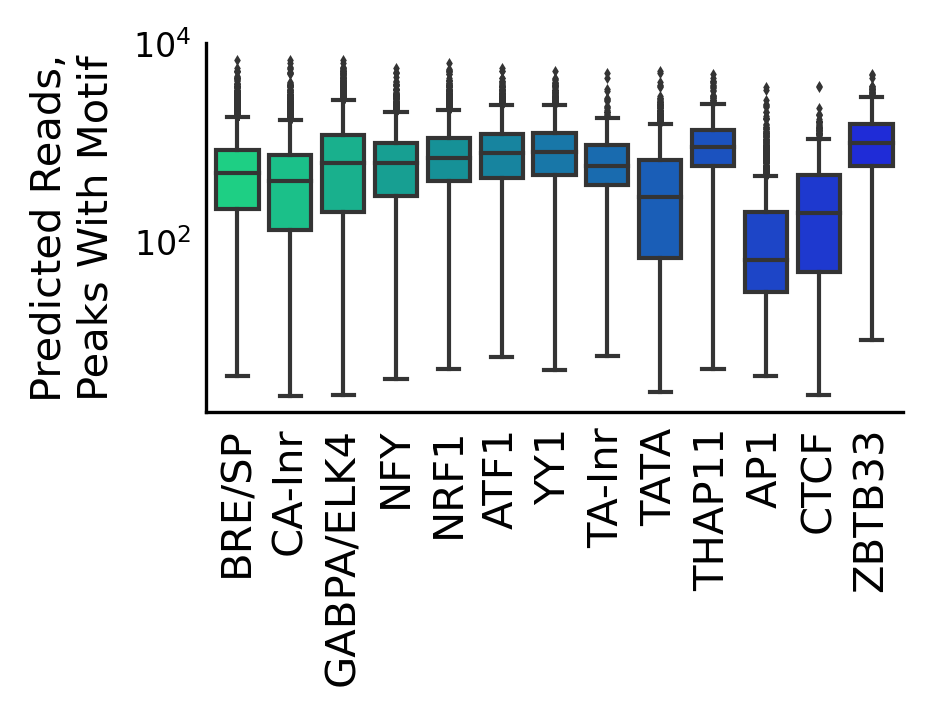

In [42]:
import seaborn as sns
import pandas as pd

def seaborn_boxplot(x_vals, y_vals, xlabel, ylabel, xticks = motif_keys_to_labels, ylog=False, hline_at=None):
    df = pd.DataFrame({xlabel : x_vals,
                       ylabel : y_vals})
    
    plt.figure(figsize=(3,1.6), dpi=300)
    
    if hline_at is not None:
        plt.hlines(hline_at, -0.5, len(x_vals), color='r',alpha=0.5, linestyle="--", zorder=1)
    
    sns.boxplot(x = xlabel,
                y = ylabel,
                data = df,
                palette = "winter_r",
                fliersize=0.5, linewidth=1)
    
    xmin, xmax = plt.gca().get_xlim()
    plt.gca().set_xlim(xmin - 0.1, xmax + 0.1)
    plt.xticks(range(len(xticks)), xticks, rotation=90)
    plt.yticks(fontsize=8)
    if ylog:
        plt.semilogy()
    
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)
    plt.tick_params(left=False, bottom=False, length=0)
    plt.xlabel("")
    
    plt.show()
    

def plot_logcounts_boxplots(val_pred_counts, peaks_with_motif_bools):
    x_vals = []
    y_vals = []
    
    for motif_key in motif_keys:
        val_pred_counts_with_hit = val_pred_counts[peaks_with_motif_bools[motif_key]].squeeze()

        x_vals.extend([motif_key] * len(val_pred_counts_with_hit))
        y_vals.extend(val_pred_counts_with_hit)
        
    seaborn_boxplot(x_vals, y_vals, "Motif", "Predicted Reads,\nPeaks With Motif",
                    ylog=True)
    

def plot_counts_boxplots(val_pred_counts, peaks_with_motif_bools):
    x_vals = []
    y_vals = []
    
    for motif_key in motif_keys:
        val_pred_counts_with_hit = val_pred_counts[peaks_with_motif_bools[motif_key]].squeeze()

        x_vals.extend([motif_key] * len(val_pred_counts_with_hit))
        y_vals.extend(val_pred_counts_with_hit)
        
    seaborn_boxplot(x_vals, y_vals, "Motif", "Predicted Reads,\nPeaks With Motif",
                    ylog=False)
    
    
def plot_median_logcounts_differences(val_pred_counts, peaks_with_motif_bools, ablated_pred_logcounts):
    x_vals = []
    y_vals = []
    
    for motif_key in motif_keys:
        print(motif_key)
        val_pred_counts_with_hit = val_pred_counts[peaks_with_motif_bools[motif_key]]
        log_diffs = np.log10(np.exp(ablated_pred_logcounts[motif_key].squeeze()) / val_pred_counts_with_hit)
        
        median_diffs = np.median(log_diffs, axis=1)

        x_vals.extend([motif_key] * len(median_diffs))
        y_vals.extend(median_diffs)
        
        
    seaborn_boxplot(x_vals, y_vals, "Motif", r'$log_{10}$' + "FC,\nPredicted Reads",
                    ylog=False, hline_at=0)
    

def plot_median_counts_differences(val_pred_counts, peaks_with_motif_bools, ablated_pred_logcounts):
    x_vals = []
    y_vals = []
    
    for motif_key in motif_keys:
        val_pred_counts_with_hit = val_pred_counts[peaks_with_motif_bools[motif_key]]
        diffs = np.exp(ablated_pred_logcounts[motif_key].squeeze()) - val_pred_counts_with_hit 
        
        median_diffs = np.median(diffs, axis=1)

        x_vals.extend([motif_key] * len(median_diffs))
        y_vals.extend(median_diffs)
    
    seaborn_boxplot(x_vals, y_vals, "Motif", r'\delta Predicted Reads',
                    ylog=False, hline_at=0)
    
    
plot_logcounts_boxplots(og_pred_counts, peaks_with_motif_bools)
#plot_counts_boxplots(og_pred_counts, peaks_with_motif_bools)

plot_median_logcounts_differences(og_pred_counts, peaks_with_motif_bools, ablated_pred_logcounts)
#plot_median_counts_differences(og_pred_counts, peaks_with_motif_bools, ablated_pred_logcounts)

In [47]:
og_pred_counts.shape, peaks_with_motif_bools[0].shape, ablated_pred_logcounts[0].shape

((27000, 1), (27000,), (14360, 50, 1))

In [48]:
peaks_with_motif_bools[0].sum()

14105

In [49]:
(motif_hit_counts["profile"] > 0).sum(axis=0)[0]

14105